In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

In [ ]:
def dice_coe(y_true,y_pred, loss_type='jaccard'):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard'):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

In [ ]:
def ReadArrayFromFolder(folder,tipe):
  arr = []
  dirName = folder
  for file in os.listdir(folder):
    if file.endswith(".bin"):
      print(file)
      f = open(os.path.join(dirName, file), "rb")
      if tipe == 0:
        head = np.frombuffer(f.read(52), dtype='f')[0:7]
      data = np.frombuffer(f.read(), dtype=np.uint8).reshape(256, 256, 256)
      ndata = np.copy(data)
      arr.append(ndata)
  return arr

In [ ]:
in_dir = "input"
out_dir = "output"

in_data = ReadArrayFromFolder(in_dir,0)
print("---------")
out_data = ReadArrayFromFolder(out_dir,1)

tr_data_in = in_data[:9]
tr_data_out = out_data[:9]
val_data_in = in_data[9:12]
val_data_out = out_data[9:12]

tr_data_in = np.asarray(tr_data_in)
tr_data_out = np.asarray(tr_data_out)
val_data_in = np.asarray(val_data_in)
val_data_out = np.asarray(val_data_out)

tr_data_in = np.expand_dims(tr_data_in, -1)
tr_data_out = np.expand_dims(tr_data_out, -1)
val_data_in = np.expand_dims(val_data_in, -1)
val_data_out = np.expand_dims(val_data_out, -1)

tr_data_in = tr_data_in.astype('float32')
tr_data_out = tr_data_out.astype('float32')
val_data_in = val_data_in.astype('float32')
val_data_out = val_data_out.astype('float32')

print(tr_data_in.shape)
print(tr_data_out.shape)
print('total training data:', len(tr_data_in))
print('total validation data:', len(val_data_in))
print("--")
print("Total training images:", len(tr_data_in) + len(val_data_in))

7.bin
10.bin
2.bin
6.bin
1.bin
8.bin
9.bin
5.bin
3.bin
12.bin
4.bin
11.bin
---------
7.bin
10.bin
2.bin
6.bin
1.bin
8.bin
9.bin
5.bin
3.bin
12.bin
4.bin
11.bin
(9, 256, 256, 256, 1)
(9, 256, 256, 256, 1)
total training data: 9
total validation data: 3
--
Total training images: 12


In [ ]:
#Normalize
tr_data_in=tr_data_in/255
tr_data_out=tr_data_out/255
val_data_in=val_data_in/255
val_data_out=val_data_out/255

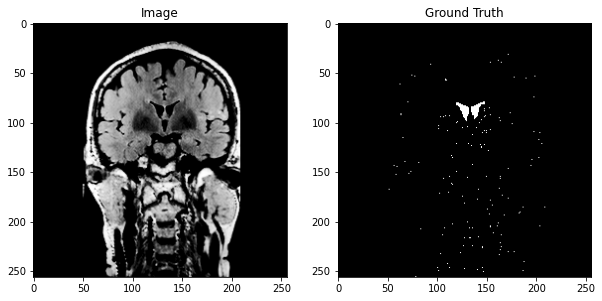

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(tr_data_in[4,:,130,:,0],cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Ground Truth")
plt.imshow(tr_data_out[4,:,130,:,0],cmap='gray')
plt.show()

In [ ]:
#Model
#Unet
def unet(input_size, start_neurons, activation, learning_rate):
    input_layer = Input(input_size)
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=activation, padding="same")(input_layer)
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=activation, padding="same")(conv1)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=activation, padding="same")(pool1)
    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=activation, padding="same")(conv2)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(pool2)
    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(conv3)
    pool3 = MaxPooling3D((2, 2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=activation, padding="same")(pool3)
    conv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=activation, padding="same")(conv4)
    pool4 = MaxPooling3D((2, 2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv3D(start_neurons * 16, (3, 3, 3), activation=activation, padding="same")(pool4)
    convm = Conv3D(start_neurons * 16, (3, 3, 3), activation=activation, padding="same")(convm)
    
    deconv4 = Conv3DTranspose(start_neurons * 8, (2, 2, 2), strides=(2, 2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=activation, padding="same")(uconv4)
    uconv4 = Conv3D(start_neurons * 8, (3, 3, 3), activation=activation, padding="same")(uconv4)

    deconv3 = Conv3DTranspose(start_neurons * 4, (2, 2, 2), strides=(2, 2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(uconv3)
    uconv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(uconv3)

    deconv2 = Conv3DTranspose(start_neurons * 2, (2, 2, 2), strides=(2, 2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=activation, padding="same")(uconv2)
    uconv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=activation, padding="same")(uconv2)

    deconv1 = Conv3DTranspose(start_neurons * 1, (2, 2, 2), strides=(2, 2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=activation, padding="same")(uconv1)
    uconv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=activation, padding="same")(uconv1)
    
    output_layer = Conv3D(1, (1, 1, 1), padding="same", activation="sigmoid")(uconv1)
    
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # model.compile(optimizer = Adam(lr = 1e-5), loss=[dice_coef_loss], metrics=['accuracy', dice_coef_multilabel])
    model.compile(optimizer = Adam(learning_rate = learning_rate), loss=[dice_loss], metrics=['accuracy', dice_coe])
    # model.compile(optimizer = Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coe])
    # model.compile(optimizer = Adam(lr = 1e-5), loss=[dice_coef_loss], metrics=['accuracy', dice_coef_multilabel])

    return model

In [ ]:
#Model
#Unet
def resnet(input_size, start_neurons, activation, learning_rate):
    input_layer = Input(input_size)
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=activation, padding="same")(input_layer)
    # gn1 = BatchNormalization()(conv1)
    conv1 = Conv3D(start_neurons * 1, (3, 3, 3), activation=activation, padding="same")(conv1)
    # gn1 = BatchNormalization()(conv1)
    conc1 = concatenate([input_layer, conv1], axis=4)
    pool1 = MaxPool3D((2, 2, 2))(conc1)

    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=activation, padding="same")(pool1)
    # gn2 = BatchNormalization()(conv2)
    conv2 = Conv3D(start_neurons * 2, (3, 3, 3), activation=activation, padding="same")(conv2)
    # gn2 = BatchNormalization()(conv2)
    conc2 = concatenate([pool1, conv2], axis=4)
    pool2 = MaxPool3D((2, 2, 2))(conc2)

    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(pool2)
    # gn3 = BatchNormalization()(conv3)
    conv3 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(conv3)
    # gn3 = BatchNormalization()(conv3)
    conc3 = concatenate([pool2, conv3], axis=4)
    pool3 = MaxPool3D((2, 2, 2))(conc3)

    conv4 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(pool3)
    # gn4 = BatchNormalization()(conv4)
    conv4 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(conv4)
    # gn4 = BatchNormalization()(conv4)
    conc4 = concatenate([pool3, conv4], axis=4)

    conv5 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(conc4)
    # gn5 = BatchNormalization()(conv5)
    conv5 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(conv5)
    # gn5 = BatchNormalization()(conv5)
    conc5 = concatenate([conc4, conv5], axis=4)

    conv6 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(conc5)
    # gn6 = BatchNormalization()(conv6)
    conv6 = Conv3D(start_neurons * 4, (3, 3, 3), activation=activation, padding="same")(conv6)
    # gn6 = BatchNormalization()(conv6)
    conc6 = concatenate([conc5, conv6], axis=4)

    up7 = concatenate([Conv3DTranspose(start_neurons * 4, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc6), conc3], axis=4)
    conv7 = Conv3D(start_neurons * 4, (3, 3, 3), activation='relu', padding='same')(up7)
    # gn7 = BatchNormalization()(conv7)
    conv7 = Conv3D(start_neurons * 4, (3, 3, 3), activation='relu', padding='same')(conv7)
    # gn7 = BatchNormalization()(conv7)
    conc7 = concatenate([up7, conv7], axis=4)

    conv8 = Conv3D(start_neurons * 4, (3, 3, 3), activation='relu', padding='same')(conc7)
    # gn8 = BatchNormalization()(conv8)
    conv8 = Conv3D(start_neurons * 4, (3, 3, 3), activation='relu', padding='same')(conv8)
    # gn8 = BatchNormalization()(conv8)
    conc8 = concatenate([conc7, conv8], axis=4)

    up9 = concatenate([Conv3DTranspose(start_neurons * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc8), conc2], axis=4)
    conv9 = Conv3D(start_neurons * 2, (3, 3, 3), activation='relu', padding='same')(up9)
    # gn9 = BatchNormalization()(conv9)
    conv9 = Conv3D(start_neurons * 2, (3, 3, 3), activation='relu', padding='same')(conv9)
    # gn9 = BatchNormalization()(conv9)
    conc9 = concatenate([up9, conv9], axis=4)

    conv10 = Conv3D(start_neurons * 4, (3, 3, 3), activation='relu', padding='same')(conc9)
    # gn10 = BatchNormalization()(conv10)
    conv19 = Conv3D(start_neurons * 4, (3, 3, 3), activation='relu', padding='same')(conv10)
    # gn10 = BatchNormalization()(conv10)
    conc10 = concatenate([conc9, conv10], axis=4)

    up11 = concatenate([Conv3DTranspose(start_neurons * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc10), conc1], axis=4)
    conv11 = Conv3D(start_neurons * 2, (3, 3, 3), activation='relu', padding='same')(up11)
    # gn11 = BatchNormalization()(conv11)
    conv11 = Conv3D(start_neurons * 2, (3, 3, 3), activation='relu', padding='same')(conv11)
    # gn11 = BatchNormalization()(conv11)
    conc11 = concatenate([up11, conv11], axis=4)
    
    output_layer = Conv3D(1, (1, 1, 1), padding="same", activation="sigmoid")(conc11)
    
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # model.compile(optimizer = Adam(lr = 1e-5), loss=[dice_coef_loss], metrics=['accuracy', dice_coef_multilabel])
    model.compile(optimizer = Adam(learning_rate = learning_rate), loss=[dice_loss], metrics=['accuracy', dice_coe])
    # model.compile(optimizer = Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coe])
    # model.compile(optimizer = Adam(lr = 1e-5), loss=[dice_coef_loss], metrics=['accuracy', dice_coef_multilabel])

    return model

In [ ]:
#Set Activation
activation="relu"

#Set learning rate
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

smooth = 1.
size = 256

In [ ]:
model = resnet((256,256,256,1), 4, activation, lr_schedule)
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 25 0                                            
__________________________________________________________________________________________________
conv3d_46 (Conv3D)              (None, 256, 256, 256 112         input_3[0][0]                    
__________________________________________________________________________________________________
conv3d_47 (Conv3D)              (None, 256, 256, 256 436         conv3d_46[0][0]                  
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 256, 256, 256 0           input_3[0][0]                    
                                                                 conv3d_47[0][0]            

In [ ]:
#Train
monitor = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights=True)
result = model.fit(tr_data_in, tr_data_out,validation_data=(
            val_data_in, val_data_out), batch_size=1, epochs=120, verbose=1, callbacks=[monitor])

Epoch 1/120
9/9 [==============================] - 27s 3s/step - loss: 0.9910 - accuracy: 0.9421 - dice_coe: 0.0090 - val_loss: 0.9883 - val_accuracy: 0.9691 - val_dice_coe: 0.0117
Epoch 2/120
9/9 [==============================] - 24s 3s/step - loss: 0.9909 - accuracy: 0.9743 - dice_coe: 0.0091 - val_loss: 0.9882 - val_accuracy: 0.9735 - val_dice_coe: 0.0118
Epoch 3/120
9/9 [==============================] - 25s 3s/step - loss: 0.9909 - accuracy: 0.9769 - dice_coe: 0.0091 - val_loss: 0.9882 - val_accuracy: 0.9742 - val_dice_coe: 0.0118
Epoch 4/120
9/9 [==============================] - 26s 3s/step - loss: 0.9909 - accuracy: 0.9768 - dice_coe: 0.0091 - val_loss: 0.9881 - val_accuracy: 0.9720 - val_dice_coe: 0.0119
Epoch 5/120
9/9 [==============================] - 25s 3s/step - loss: 0.9908 - accuracy: 0.9736 - dice_coe: 0.0092 - val_loss: 0.9881 - val_accuracy: 0.9666 - val_dice_coe: 0.0119
Epoch 6/120
9/9 [==============================] - 25s 3s/step - loss: 0.9908 - accuracy: 0.968

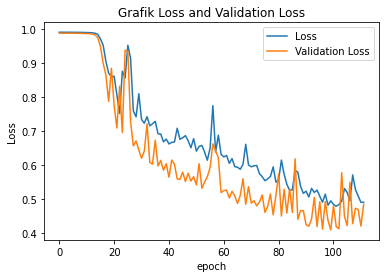

In [ ]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Grafik Loss and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Validation Loss'], loc='best')
plt.show()

In [ ]:
score = model.evaluate(val_data_in, val_data_out, verbose=1)

print(score)
print('Evaluation loss:', score[0])
print('Evaluation Accuracy:', score[1])
print('Dice Coefficient:', score[2])

1/1 [==============================] - 16s 16s/step - loss: 0.4221 - accuracy: 0.9981 - dice_coe: 0.5779
[0.4221409857273102, 0.9980852007865906, 0.5778589844703674]
Evaluation loss: 0.4221409857273102
Evaluation Accuracy: 0.9980852007865906
Dice Coefficient: 0.5778589844703674


In [ ]:
tes = ReadArrayFromFolder("tes/",0)
tes = np.asarray(tes)
tes = np.expand_dims(tes, -1)
tes = tes.astype('float32')

predict = model.predict(tes, batch_size=1, verbose=1)

13.bin
1/1 [==============================] - 0s 270ms/step


In [ ]:
tes = tes[0,:,:,:,0]
predict = predict[0,:,:,:,0]
print(predict.shape)


(256, 256, 256)


In [ ]:
# predict.astype('uint8').tofile("tes/predict.bin")

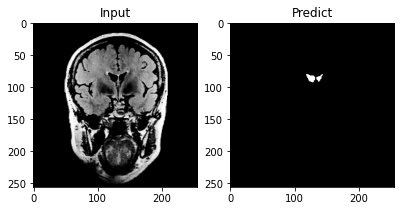

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(tes[:,112,:], cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Predict")
plt.imshow(predict[:,112,:], cmap='gray')

plt.show()